# Homework 3, Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import walk
import cv2 as cv

%matplotlib inline
figsize = (15,22)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    
def print_box(img, pts, is_rect=True):
    img = img.copy()
    if is_rect:
        x,y,w,h = pts
        cv.rectangle(img, (x,y), (x+w, y+h), color=255)
    else:
        pts = np.int0(cv.boxPoints(pts))
        cv.polylines(img, [pts], isClosed=True, color=255)
        
    cv.imshow('img', img)
    cv.waitKey(120)
    

def print_box_jup(img, box):
    img = img.copy()
    x,y,w,h = box
    cv.rectangle(img, (x,y), (x+w, y+h), color=(255,0,0))
    _plot(img)

## Meanshift algorithm

In [2]:
def video2frames(filename='slow_traffic_small.mp4', output_dir='data/CarOpenCV/img/', limit=180, freq=10):
    cap = cv.VideoCapture('slow_traffic_small.mp4')
    count = 0
    limit = 1e7 if limit == None else limit
    for i in range(limit):
        ret, frame = cap.read()
        if ret:
            if i % 10 != 0: continue 
            count += 1
            cv.imwrite(output_dir + 'frame-%02d.jpg' % count, frame)
        else:
            break

def init_track_window(path, start_frame=0, sep=','):
    boxes = pd.read_csv(path + 'groundtruth_rect.txt', header=None, sep=sep, names=['x', 'y', 'w', 'h'])
    return boxes.values[start_frame]

def track_obj(path, track_window, minHsv=(0., 60., 60.), meanshift=True):
    '''
    track_window - tracking window for the 1 frame
    minHsv - minimum color to add to histogram with which we will
            track the window. Without it low-intensity noisy will decrease model performance
    '''
    frame_coll = []
    for (dirpath, dirnames, filenames) in walk(path + 'img/'):
        for f in filenames:
            file_path = dirpath + f
            img = cv.imread(file_path, cv.IMREAD_COLOR)
#             img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            frame_coll.append(img)
        
    # setup initial location of window
    c,r,w,h = track_window
    track_window = (c,r,w,h)
    
    start_i = 0
    frame = frame_coll[start_i]
    
    # set up the ROI for tracking
    roi = frame[r:r+h, c:c+w]
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_roi, np.array(minHsv), np.array((180.,255.,255.)))
    roi_hist = cv.calcHist([hsv_roi], [0], mask, histSize=[60], ranges=[0,180])
    roi_hist = cv.normalize(roi_hist, 0, 255, cv.NORM_MINMAX)
    
    mean_shift_iterations=10
    term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, mean_shift_iterations, 1)
    for i in range(start_i + 1, len(frame_coll)):
            frame = frame_coll[i]
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            dst = cv.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
    
            if i == start_i + 1: _plot(dst)
            if meanshift:
                ret, track_window = cv.meanShift(dst, track_window, term_crit)
                print_box(frame, track_window)
            else:
                ret, track_window = cv.CamShift(dst, track_window, term_crit)
                print_box(frame, ret, is_rect=False)
            
    cv.destroyAllWindows()

### DragonBaby Demo

As we can see here baby's head is pretty unique color histogram for the image thus afper back projection there not that much "hot" areas. This makes the tracking pretty robust. But closely to the end of the sequence there are missing frames and thus our window gets lost (baby's head is appears far away from previous position thus mean shift founds another local maxima)

To avoid such problems we might extend the tracking functionality. That is, when we find the window position for current frame, we should also calculate whether it's elements are significantly smaller than it used to be. IF so, we might assume that object was lost and thus start the scan of entiry image to find it.

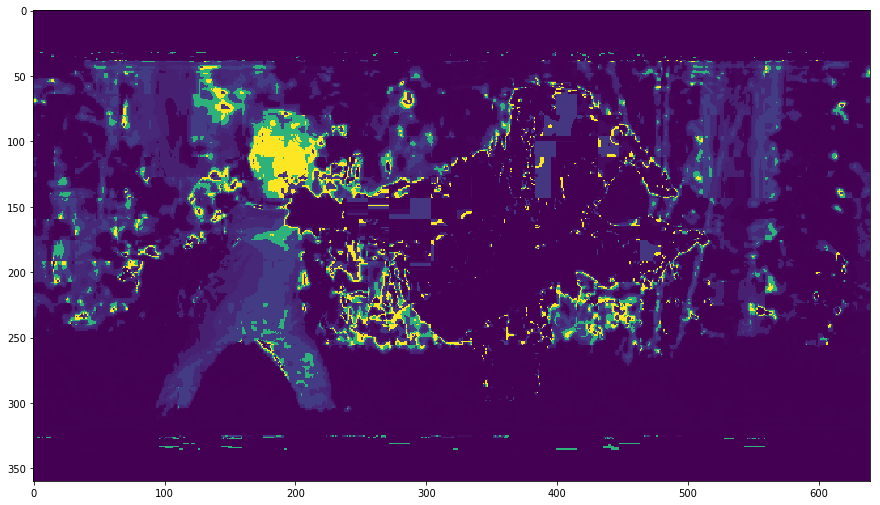

In [73]:
path = 'data/DragonBaby/'
track_obj(path, init_track_window(path))

### Deer Demo

In the second case, if we stick to the original track window, mean shift will perform poorly as soon as the second frame. That's because it covers a lot of water from background and thus water becomes more probable than deers in BackProjected image.

So we chage window a little so that it covers mostly deer's head, which increases performance. But as you can see form pixel probability  image below, pixels in deers head are similar to both deers bodies. That's the reason why meanshift gets lost and track other deer back, when they become closer to each other

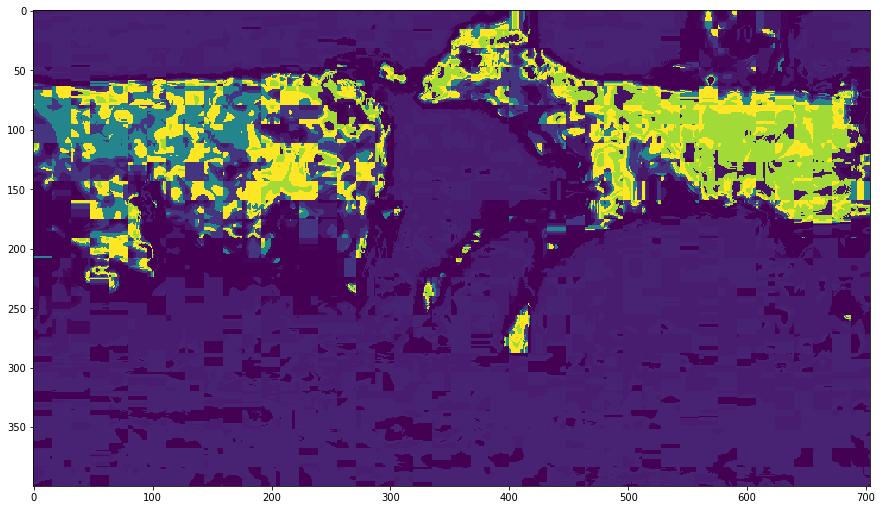

In [64]:
path = 'data/Deer/'
track_window = init_track_window(path)
track_window = (track_window[0] + 35, track_window[1], track_window[2] - 5, track_window[3] - 10)
track_obj(path, track_window)

### Upcoming Car Demo

The third demo is very representative. Here we have a white car driving to the camera on road. Since road and car have easily distinguishable, mean shift works here flawlessly.

On the other hand, we could identify a drawback of mean shift in this demo. That is, it has a fixed dimention of tracking window. And when size of trackable object changes, our tracking doesn't work as expected.

In other words, as you can see originally, when car was far away, we were tracking the entire window. But as car comes closer to a camera and thus becomes bigger, we are tracking smaller and smaller part of the window. 

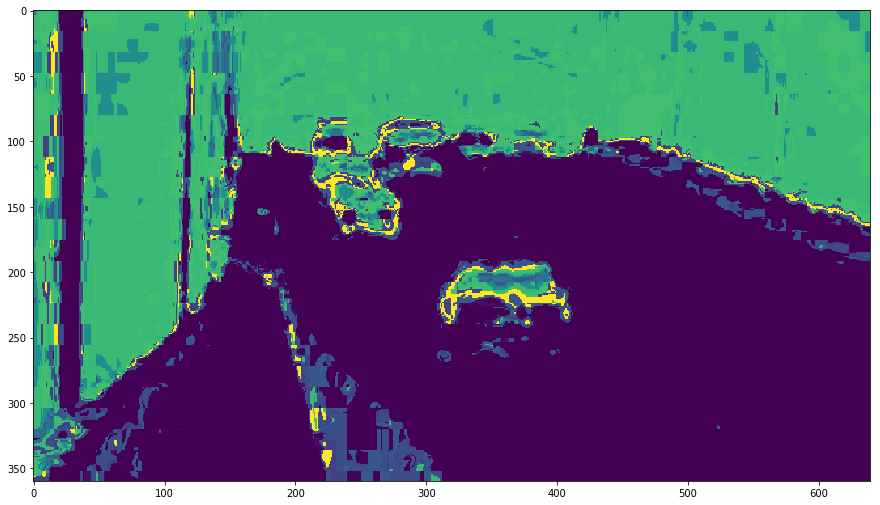

In [74]:
path = 'data/CarOpenCV/'
track_window = init_track_window(path)
track_obj(path, track_window, minHsv=(0., 25.,25.))

## Camshift algorithm

The problem with constant tracking windows is solved with an enhanced Meanshift algorithm, which is called CAMShift. It works similarly to Meanshift but when tracking window converges on each iteration, it also updates the size of tracking window based on its new center of mass and color probability distrubition in that area. You can check detaials regarding formulas for update in [this paper](http://webpages.iust.ac.ir/mahfathy/_vti_pvt/Papers/Object%20Tracking%20Using%20Improved%20CAMShift%20.pdf)

So let's check whether it will really solve the problem with window tracking from the car demo, where it is moving towards the camera and thus becomes bigger and bigger

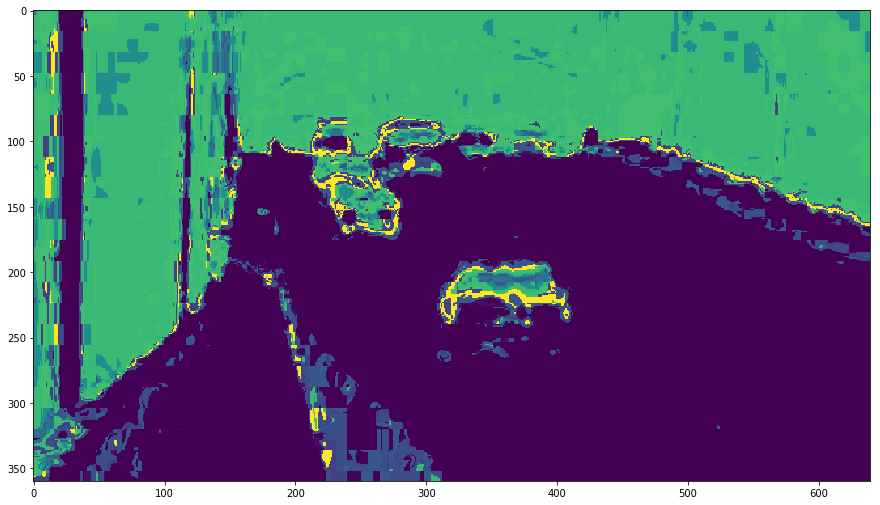

In [76]:
path = 'data/CarOpenCV/'
track_window = init_track_window(path)
track_obj(path, track_window, minHsv=(0., 25.,25.), meanshift=False)

And let's also check how CAMShift works on other datasets, which gives improvements as well (with dragon baby tracker isn't lost after missing frames, as it was with meanshift algorithm)

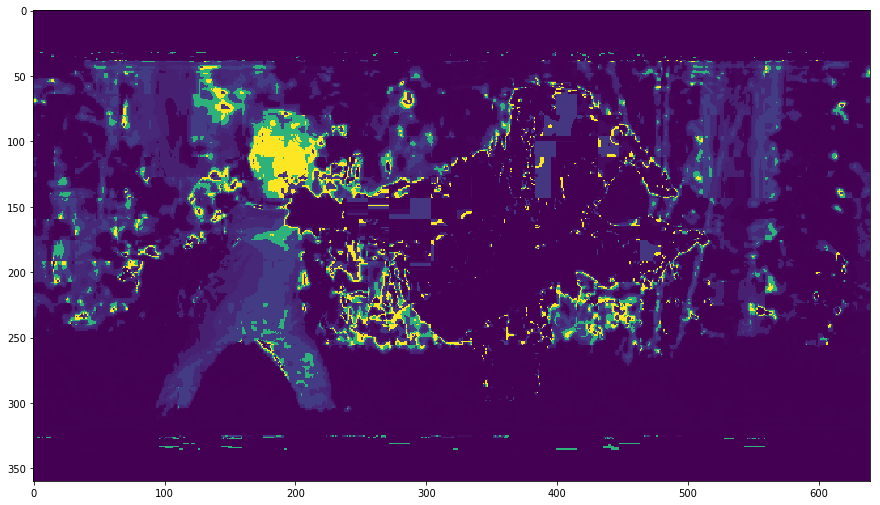

In [77]:
path = 'data/DragonBaby/'
track_obj(path, init_track_window(path), meanshift=False)

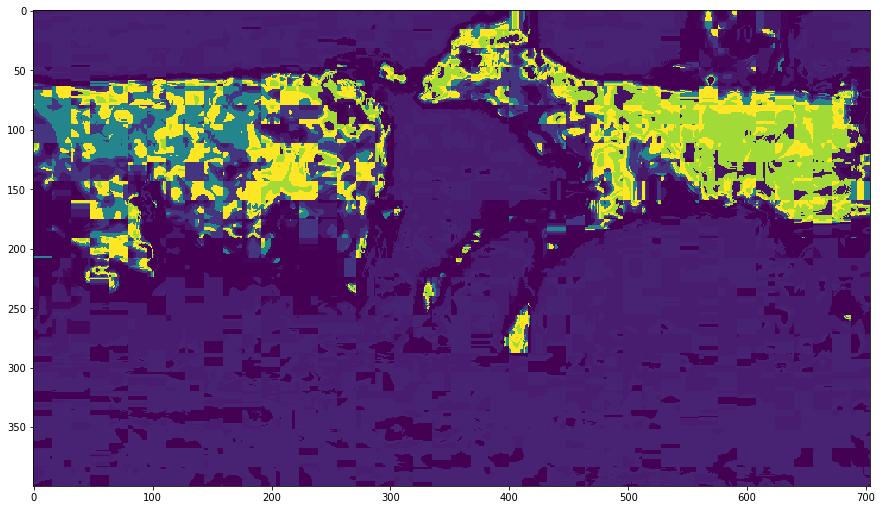

In [78]:
path = 'data/Deer/'
track_window = init_track_window(path)
track_window = (track_window[0] + 35, track_window[1], track_window[2] - 5, track_window[3] - 10)
track_obj(path, track_window, meanshift=False)

## Meanshift clustering

In [30]:
from sklearn.cluster import MeanShift,estimate_bandwidth
from itertools import cycle

def kmeans_clustering(path):
    df = pd.read_csv(path)
    
    bandwidth = estimate_bandwidth(df, quantile=.1, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth/2, bin_seeding=True)
    ms.fit(df)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = labels.max() + 1
 
    #%% Plot result
    plt.figure(figsize=figsize)
    plt.figure(1)
    plt.clf()
#     plt.scatter(df['p1'], df['p2'])
 
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(df.values[my_members, 0], df.values[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1],
             'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

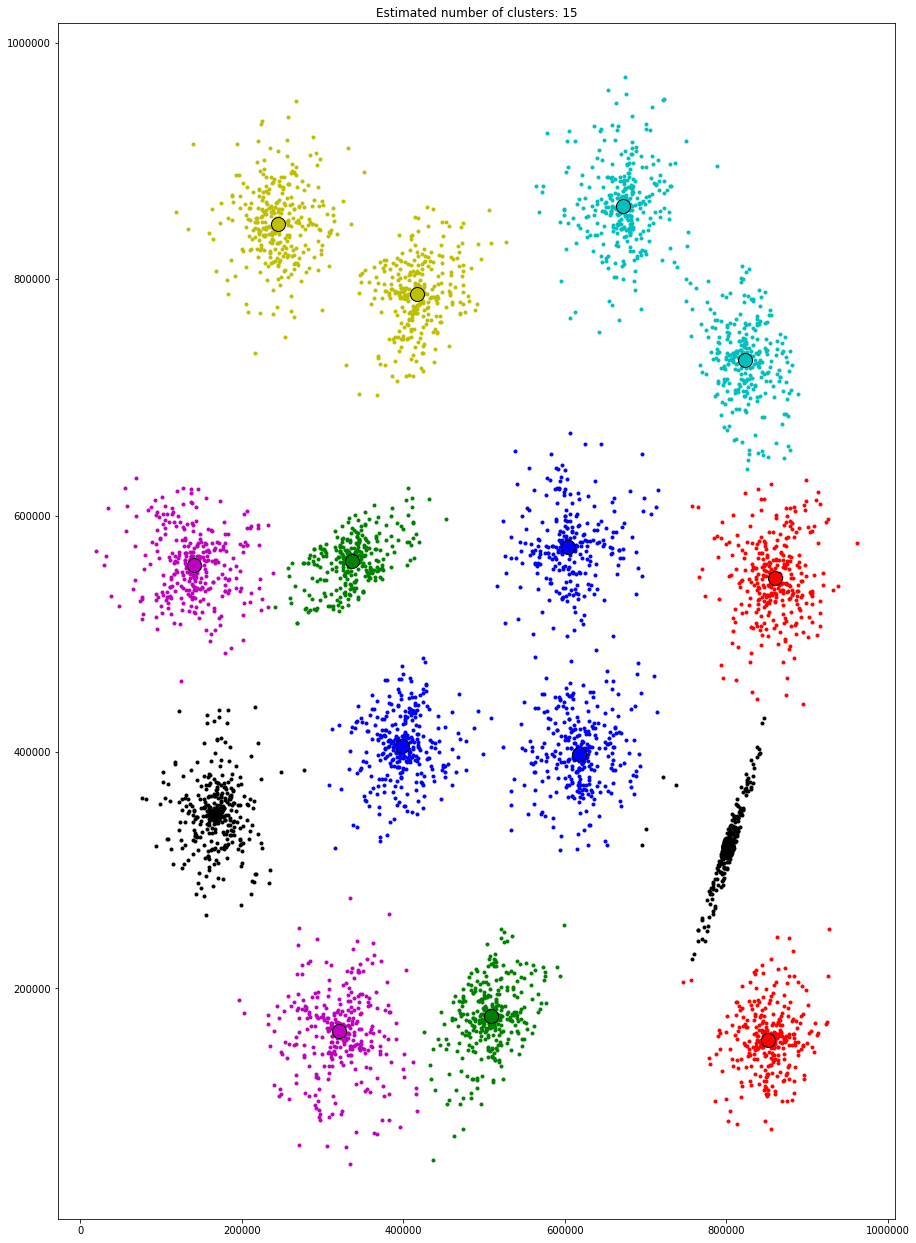

In [31]:
kmeans_clustering("data/clustering/s1.csv")

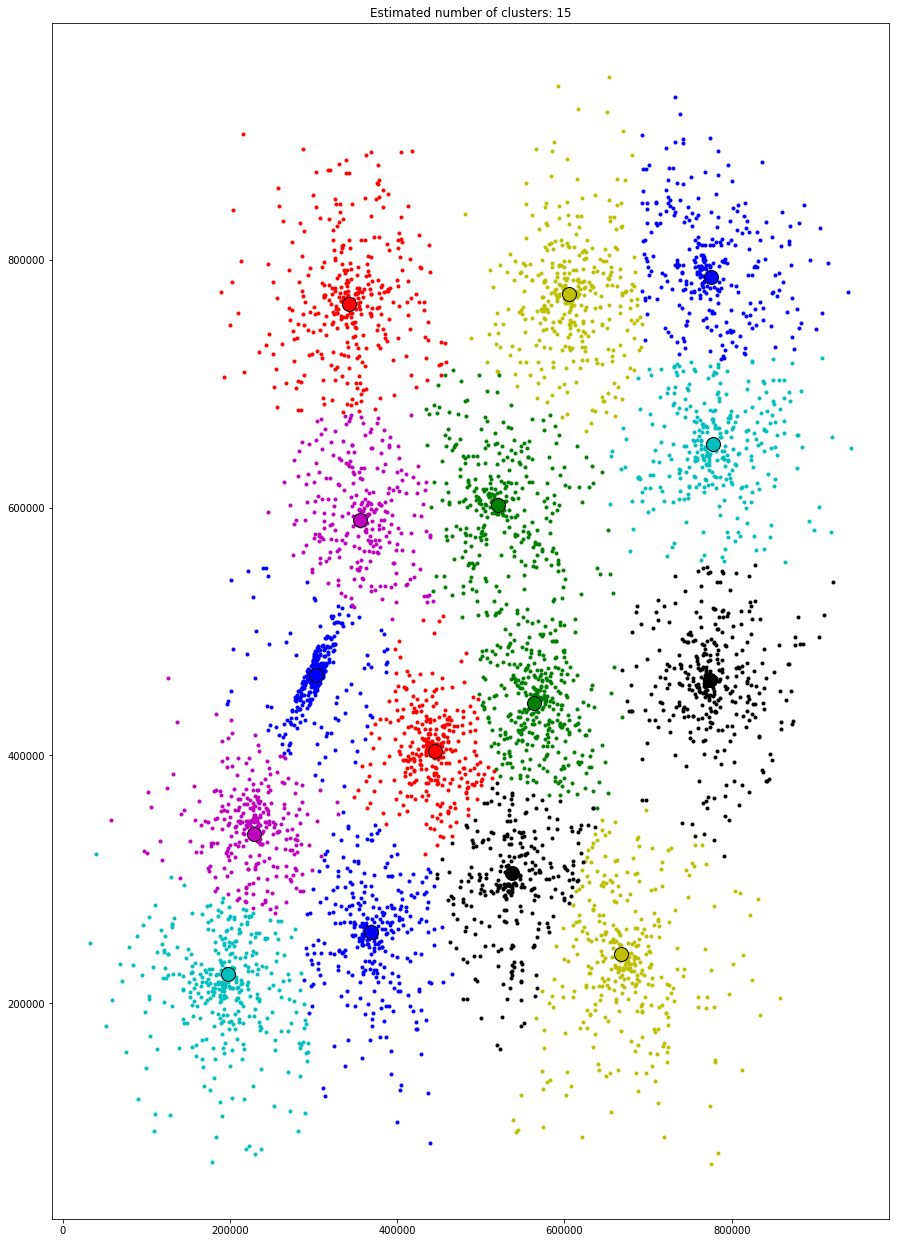

In [32]:
kmeans_clustering("data/clustering/s3.csv")

What we just demonstrated is the core of meanshift itself. That is, when we put a tracking windows at some random position, it will converge to a local maximum of point intensity. And this can be used to successfully cluster data.

So once we estimated the tracking window size, we could put it at the position of each data point and start meanshift algorithm. Then wherever the thracking window ends up will be the cluster of that point. Similarly, the amount of unique positions of tracking windows after algorithm completion will be the number of clusters in data.

This algorithm is similar to k-means since it also works with centroids. Difference is that in k-means we must know or guess the number of cluster in advance, while meanshift will estimate it on its own. But it comes with a price since meanshift is significantly slower than k-means